In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc



Importing the Dataset "airbnb.csv".

In [139]:
df_original = pd.read_csv('airbnb.csv', low_memory=False)

Viewing the Data.

In [140]:
df_original.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1,NaN
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,NaN
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0,NaN
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52,NaN
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,NaN


Dropping 'id' and 'host_id' because they do not contribute to our model. Also, dropping 'license' because it is a null column and irrelevant.

In [141]:
df=df_original.drop(columns=["id","host_id","license"])

Viewing the shape (Rows, Columns) of the Dataset.

In [142]:
df.shape

(42931, 15)

Inspect Column Names.

In [143]:
df.columns

Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

Basic Info.

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42931 entries, 0 to 42930
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            42919 non-null  object 
 1   host_name                       42926 non-null  object 
 2   neighbourhood_group             42931 non-null  object 
 3   neighbourhood                   42931 non-null  object 
 4   latitude                        42931 non-null  float64
 5   longitude                       42931 non-null  float64
 6   room_type                       42931 non-null  object 
 7   price                           42931 non-null  int64  
 8   minimum_nights                  42931 non-null  int64  
 9   number_of_reviews               42931 non-null  int64  
 10  last_review                     32627 non-null  object 
 11  reviews_per_month               32627 non-null  float64
 12  calculated_host_listings_count  

Handling Null Values

In [145]:
null_counts = df.isnull().sum().reset_index()
null_counts.columns = ['Feature', 'Null Value Count']

# Filter to show only features with at least one null value
null_counts = null_counts[null_counts['Null Value Count'] > 0]

null_counts = df.isnull().sum().reset_index()
null_counts.columns = ['Feature', 'Null Value Count']
null_counts



,Feature,Null Value Count
0,name,12
1,host_name,5
2,neighbourhood_group,0
3,neighbourhood,0
4,latitude,0
5,longitude,0
6,room_type,0
7,price,0
8,minimum_nights,0
9,number_of_reviews,0


We have 12 and 5 null values in 'name' column and 'host_name' column respectively. Replacing all of those with "unknown".

In [146]:
df['name'] = df['name'].fillna('unknown')
df['host_name'] = df['host_name'].fillna('unknown')

We have 10304 missing values in both 'last_review' as well as 'reviews_per_month'. Replacing the null last_review values by 0 and reviews_per_month by the median value using the SimpleImputer.

In [147]:
null_rows_idx = df.isnull().any(axis=1)
df["last_review"] = df["last_review"].fillna(0)
df.loc[null_rows_idx].head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
15,Room in the heart of Astoria,Boris,Queens,Astoria,40.76336,-73.92099,Private room,55,30,0,0,NaN,1,0,0
47,Country space in the city,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,30,0,0,NaN,1,0,0
88,Room in Beautiful Townhouse.,L,Bronx,Mott Haven,40.80635,-73.92201,Private room,60,30,0,0,NaN,1,83,0
101,1 Bedroom in 2 Bdrm Apt- Upper East,Jessica,Manhattan,Upper East Side,40.77449,-73.95308,Private room,130,14,0,0,NaN,2,0,0
114,Beautiful Uptown Manhattan apartmnt,Douglas,Manhattan,Harlem,40.80255,-73.95803,Private room,200,30,0,0,NaN,1,365,0


In [148]:
imputer = SimpleImputer(strategy='median')
df['reviews_per_month'] = imputer.fit_transform(df[['reviews_per_month']])
df[['reviews_per_month']].median()

reviews_per_month    0.52
dtype: float64

All the null values have been handled.

In [149]:
df.isnull().sum()

name                              0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

Looking in to the consistency of the data types of all our features.

In [150]:
print(df.dtypes)

name                               object
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
dtype: object


Converting 'last_review' column from object to datetime.

In [151]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df.head(5)

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1
1,BlissArtsSpace!,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0
2,Cozy Clean Guest Room - Family Apt,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0
3,Large Furnished Room Near B'way,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52
4,"Large Sunny Brooklyn Duplex, Patio + Garden",Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1


In [152]:
print(df.dtypes)

name                                      object
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
dtype: object


Removing any duplicate observations if there are any.

In [153]:
df.drop_duplicates(inplace=True)

There are no duplicate rows. Hence, the shape of our dataframe remains the same as the original.

In [154]:
df.shape

(42921, 15)

Inspecting Variables.

In [155]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,42921.000000,42921.000000,42921.000000,42921.000000,42921.000000,32626,42921.000000,42921.000000,42921.000000,42921.000000
mean,40.728267,-73.943658,200.189651,18.115165,25.862002,2021-08-16 22:13:45.795377920,1.013349,24.057082,140.255865,7.738310
min,40.500314,-74.251907,0.000000,1.000000,0.000000,2011-05-12 00:00:00,0.010000,1.000000,0.000000,0.000000
25%,40.687480,-73.981750,75.000000,2.000000,1.000000,2020-03-10 00:00:00,0.220000,1.000000,0.000000,0.000000
50%,40.724020,-73.952600,125.000000,7.000000,5.000000,2022-11-23 00:00:00,0.520000,1.000000,89.000000,1.000000
75%,40.762298,-73.924020,200.000000,30.000000,24.000000,2023-02-01 00:00:00,1.170000,4.000000,289.000000,7.000000
max,40.911380,-73.710870,99000.000000,1250.000000,1842.000000,2023-03-06 00:00:00,86.610000,526.000000,365.000000,1093.000000
std,0.057646,0.056631,895.147544,27.464470,56.621574,NaN,1.584775,80.877199,141.994403,18.292005


Correlation Heatmap for the numeric features.

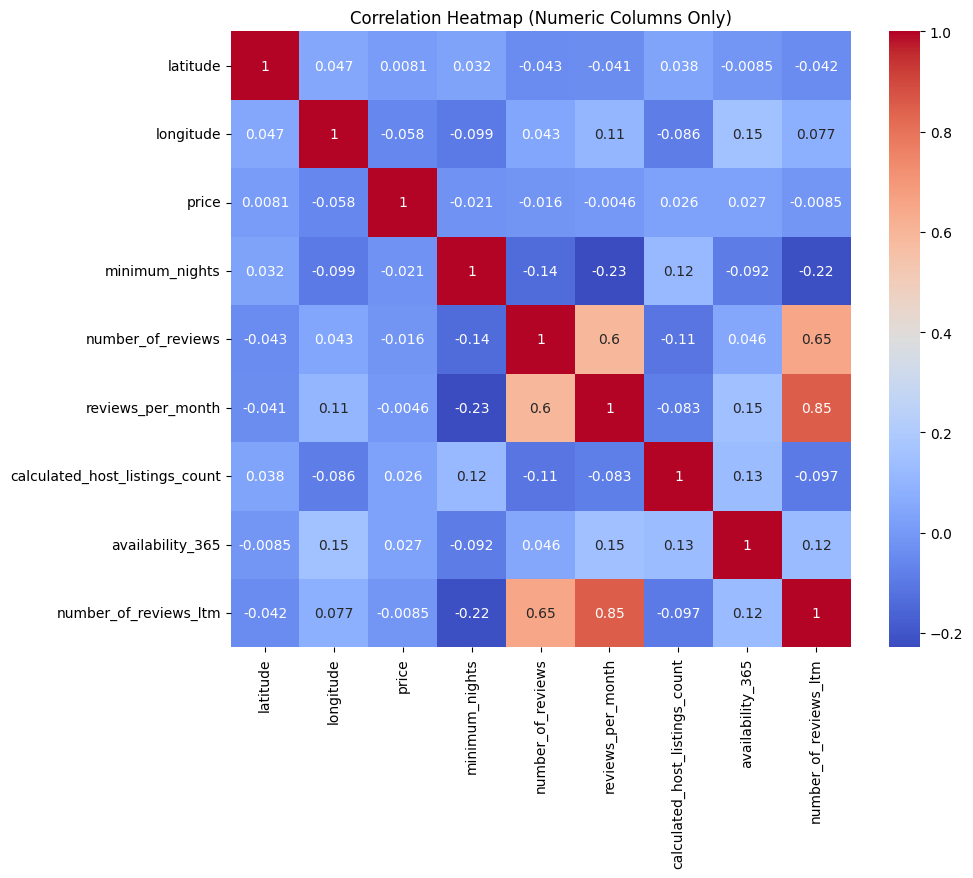

In [156]:
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_data = df[numeric_cols]

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

In [157]:
print((df['price'] > 1000).sum())
print((df['price'] <= 1000).sum())


625
42296


In [158]:
df = df[df['price'] <= 1000]


Creating a new column "price_range" where price<500 is Affordable and price>500 is Expensive

In [159]:
def classify_price(price):
    if price <= 500:
        return 'Affordable'
    else:
        return 'Expensive'

df['price_range'] = df['price'].apply(classify_price)
df.head()


,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_range
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1,Affordable
1,BlissArtsSpace!,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,Affordable
2,Cozy Clean Guest Room - Family Apt,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0,Affordable
3,Large Furnished Room Near B'way,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52,Affordable
4,"Large Sunny Brooklyn Duplex, Patio + Garden",Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,Affordable


One Hot Encoding the Categorical Columns "neighbourhood_group" and "room_type"

In [160]:

# Selecting the categorical columns
cat_columns = ['neighbourhood_group', 'room_type']
cat_data = df[cat_columns]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = encoder.fit_transform(cat_data)

encoded_cat_df = pd.DataFrame(
    encoded_cat,
    columns=encoder.get_feature_names_out(cat_columns),
    index=df.index
)

# Dropping original categorical columns
df = df.drop(columns=cat_columns)

# Concatenating encoded columns to main DataFrame
df = pd.concat([df, encoded_cat_df], axis=1)

df.head()

,name,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,availability_365,number_of_reviews_ltm,price_range,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,Skylit Midtown Castle,Jennifer,Midtown,40.75356,-73.98559,150,30,49,2022-06-21,0.30,...,314,1,Affordable,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,BlissArtsSpace!,Garon,Bedford-Stuyvesant,40.68535,-73.95512,60,30,50,2019-12-02,0.30,...,365,0,Affordable,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Cozy Clean Guest Room - Family Apt,MaryEllen,Upper West Side,40.80380,-73.96751,75,2,118,2017-07-21,0.72,...,0,0,Affordable,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,Large Furnished Room Near B'way,Shunichi,Midtown,40.76457,-73.98317,68,2,575,2023-02-19,3.41,...,106,52,Affordable,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,"Large Sunny Brooklyn Duplex, Patio + Garden",Rebecca,Sunset Park,40.66265,-73.99454,275,60,3,2022-08-10,0.03,...,181,1,Affordable,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Because of Class Imbalance on our target variable, using SMOTE to multiply the minority class.

In [161]:
df['price_range'].value_counts()

price_range
Affordable    40961
Expensive      1335
Name: count, dtype: int64

In [162]:
from sklearn.model_selection import train_test_split

X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['price'])  # drop target price
y = df['price_range']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [163]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Use only the minority classes
smote = SMOTE(sampling_strategy={
    'Expensive': 10000
}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_smote, y_train_smote)

print("Before SMOTE:", Counter(y_train_smote))
print("After SMOTE: ", Counter(y_resampled))


Before SMOTE: Counter({'Affordable': 32768, 'Expensive': 1068})
After SMOTE:  Counter({'Affordable': 32768, 'Expensive': 10000})


Scaling the data just for Logistic Regression

In [164]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

Train-Test Split for Logistic Regression

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


Logistic Regression Model

Accuracy: 0.7963525835866262
Classification Report:
               precision    recall  f1-score   support

  Affordable       0.82      0.93      0.88      6554
   Expensive       0.61      0.35      0.44      2000

    accuracy                           0.80      8554
   macro avg       0.72      0.64      0.66      8554
weighted avg       0.78      0.80      0.77      8554



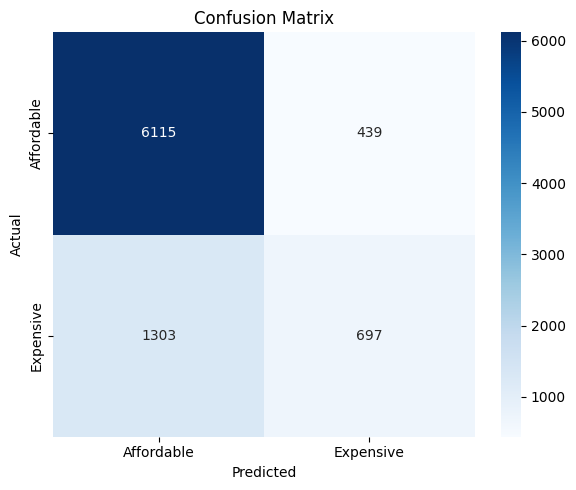

In [166]:
#Train
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

#Predict
logreg_pred = logreg_model.predict(X_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print("Classification Report:\n", classification_report(y_test, logreg_pred))

#Confusion Matrix
logreg_cm = confusion_matrix(y_test, logreg_pred, labels=logreg_model.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

ROC AUC Curve for Logistic Regression

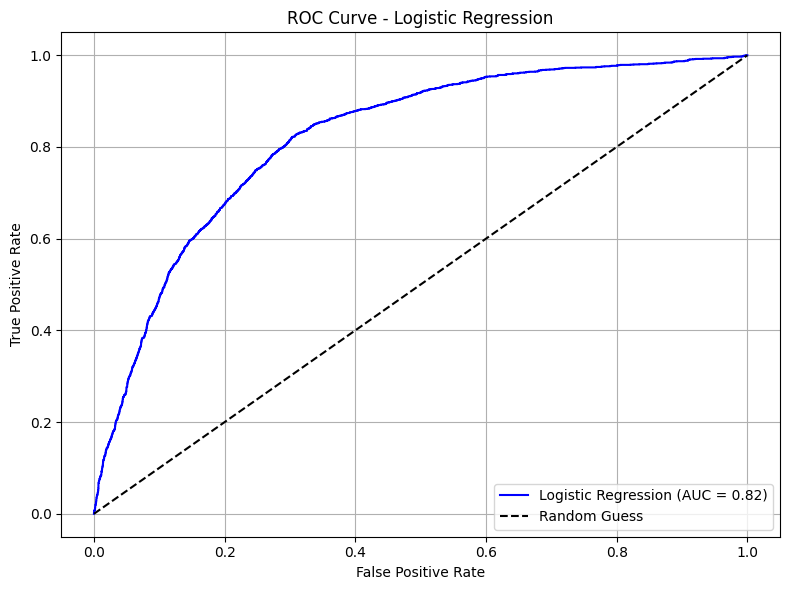

In [167]:

logreg_y_score = logreg_model.predict_proba(X_test)[:, 1]  # Probability of class 'Expensive'

logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, logreg_y_score, pos_label='Expensive')
logreg_auc = auc(logreg_fpr, logreg_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Grid Search on Logistic Regression

In [168]:
#Hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

logreg_base_model = LogisticRegression(max_iter=1000)

# Grid Search with 5-fold cross-validation
logreg_grid_search = GridSearchCV(
    estimator=logreg_base_model,
    param_grid=logreg_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

logreg_grid_search.fit(X_train, y_train)

logreg_best_model = logreg_grid_search.best_estimator_

logreg_y_pred_best = logreg_best_model.predict(X_test)

# Results
print("Best Parameters:", logreg_grid_search.best_params_)
print("Best CV Accuracy:", logreg_grid_search.best_score_)
print("Test Accuracy:", accuracy_score(y_test, logreg_y_pred_best))
print("Classification Report:\n", classification_report(y_test, logreg_y_pred_best))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best CV Accuracy: 0.7959606411013322
Test Accuracy: 0.7962356792144026
Classification Report:
               precision    recall  f1-score   support

  Affordable       0.82      0.93      0.88      6554
   Expensive       0.61      0.35      0.44      2000

    accuracy                           0.80      8554
   macro avg       0.72      0.64      0.66      8554
weighted avg       0.77      0.80      0.77      8554



Decision Tree (Using the unscaled data)

In [169]:
X_unscaled = X_resampled
y_unscaled = y_resampled

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_unscaled, y_unscaled, test_size=0.2, stratify=y_unscaled, random_state=42
)


Accuracy: 0.9289221416880992
Classification Report (Decision Tree)               precision    recall  f1-score   support

  Affordable       0.96      0.95      0.95      6554
   Expensive       0.84      0.87      0.85      2000

    accuracy                           0.93      8554
   macro avg       0.90      0.91      0.90      8554
weighted avg       0.93      0.93      0.93      8554



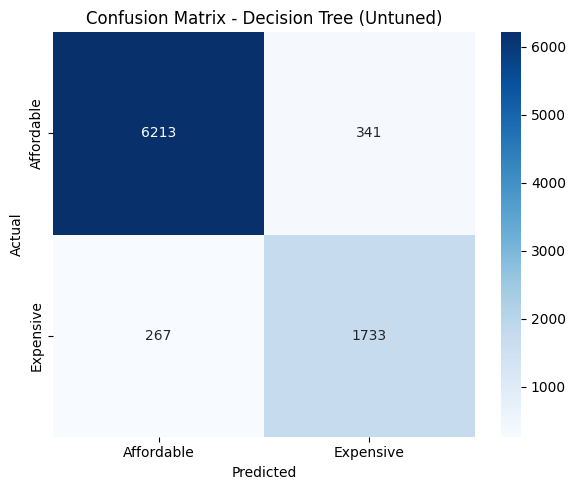

In [170]:
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_rf, y_train_rf)

# Predict
dtree_y_pred = dtree_model.predict(X_test_rf)

# Evaluate
print("Accuracy:", accuracy_score(y_test_rf, dtree_y_pred))
print("Classification Report (Decision Tree)", classification_report(y_test, dtree_y_pred))

# Confusion matrix
dtree_cm = confusion_matrix(y_test_rf, dtree_y_pred, labels=dtree_model.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(dtree_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dtree_model.classes_,
            yticklabels=dtree_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree (Untuned)")
plt.tight_layout()
plt.show()


Grid Search on Decision Tree

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy (DT GridSearch): 0.9304418985270049
Classification Report (DT GridSearch):
               precision    recall  f1-score   support

  Affordable       0.95      0.96      0.95      6554
   Expensive       0.86      0.84      0.85      2000

    accuracy                           0.93      8554
   macro avg       0.91      0.90      0.90      8554
weighted avg       0.93      0.93      0.93      8554



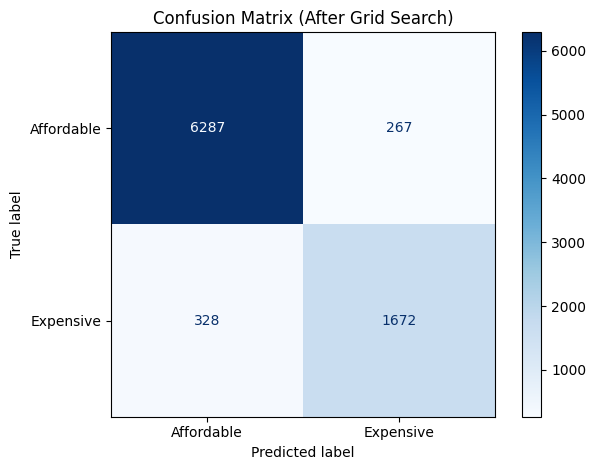

In [171]:
# Defining parameter grid for Decision Tree
dtree_gs_param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree_gs_model = DecisionTreeClassifier(random_state=42)

dtree_gs_search = GridSearchCV(
    estimator=dtree_gs_model,
    param_grid=dtree_gs_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dtree_gs_search.fit(X_train_rf, y_train_rf)

dtree_gs_y_pred = dtree_gs_search.best_estimator_.predict(X_test_rf)

# Evaluate
print("Best Parameters:", dtree_gs_search.best_params_)
print("Accuracy (DT GridSearch):", accuracy_score(y_test_rf, dtree_gs_y_pred))
print("Classification Report (DT GridSearch):\n", classification_report(y_test_rf, dtree_gs_y_pred))

# Confusion Matrix
dtree_gs_cm = confusion_matrix(y_test_rf, dtree_gs_y_pred, labels=dtree_gs_search.best_estimator_.classes_)
dtree_gs_disp = ConfusionMatrixDisplay(confusion_matrix=dtree_gs_cm,
                                       display_labels=dtree_gs_search.best_estimator_.classes_)
dtree_gs_disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (After Grid Search)")
plt.grid(False)
plt.tight_layout()
plt.show()


Feature Importance on Decsion Tree

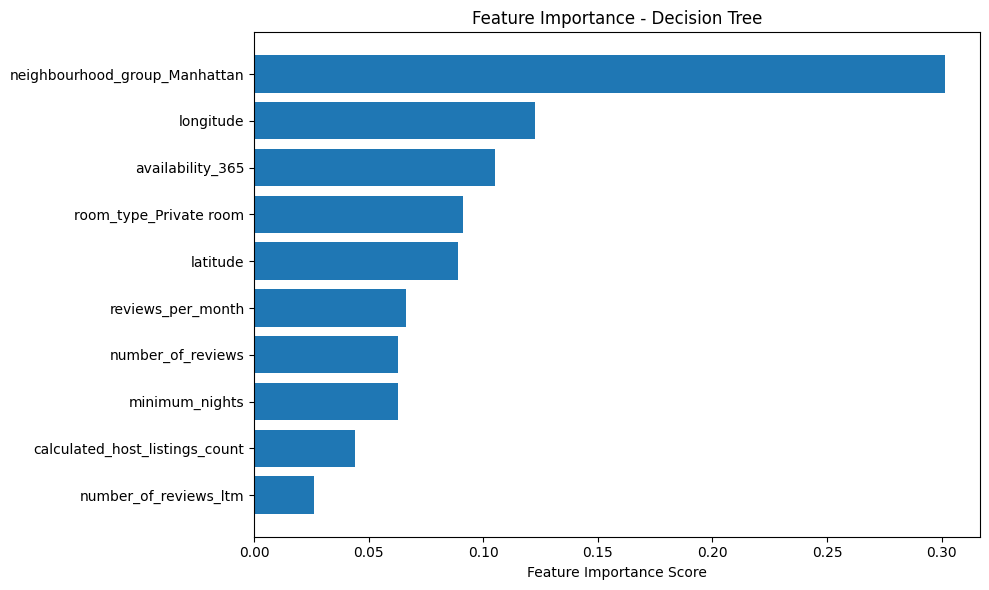

In [172]:
importances = dtree_gs_search.best_estimator_.feature_importances_

# Get corresponding feature names
feature_names = X_train_rf.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()


ROC AUC Curve for Decision Tree

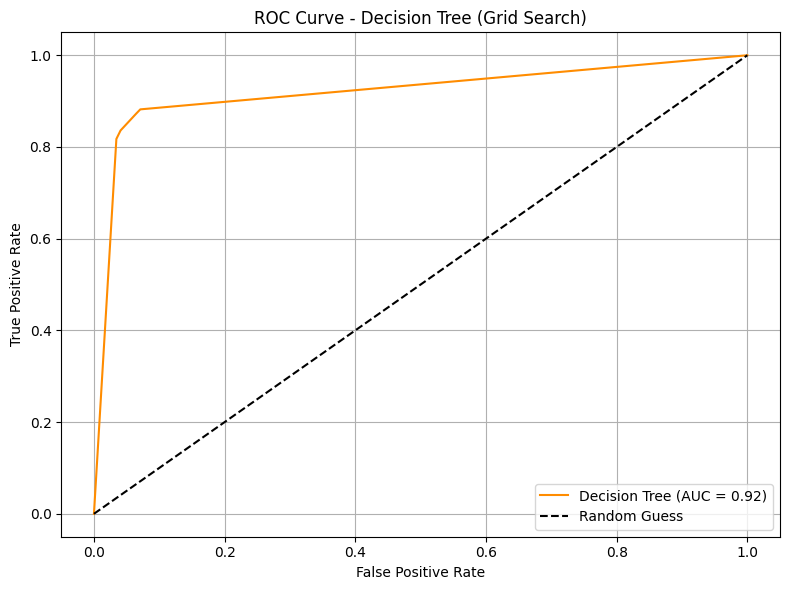

In [173]:
dtree_gs_y_score = dtree_gs_search.best_estimator_.predict_proba(X_test_rf)[:, 1]

dtree_gs_fpr, dtree_gs_tpr, _ = roc_curve(y_test_rf, dtree_gs_y_score, pos_label='Expensive')
dtree_gs_auc = auc(dtree_gs_fpr, dtree_gs_tpr)

plt.figure(figsize=(8, 6))
plt.plot(dtree_gs_fpr, dtree_gs_tpr, label=f'Decision Tree (AUC = {dtree_gs_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Grid Search)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Decision Tree Visualization

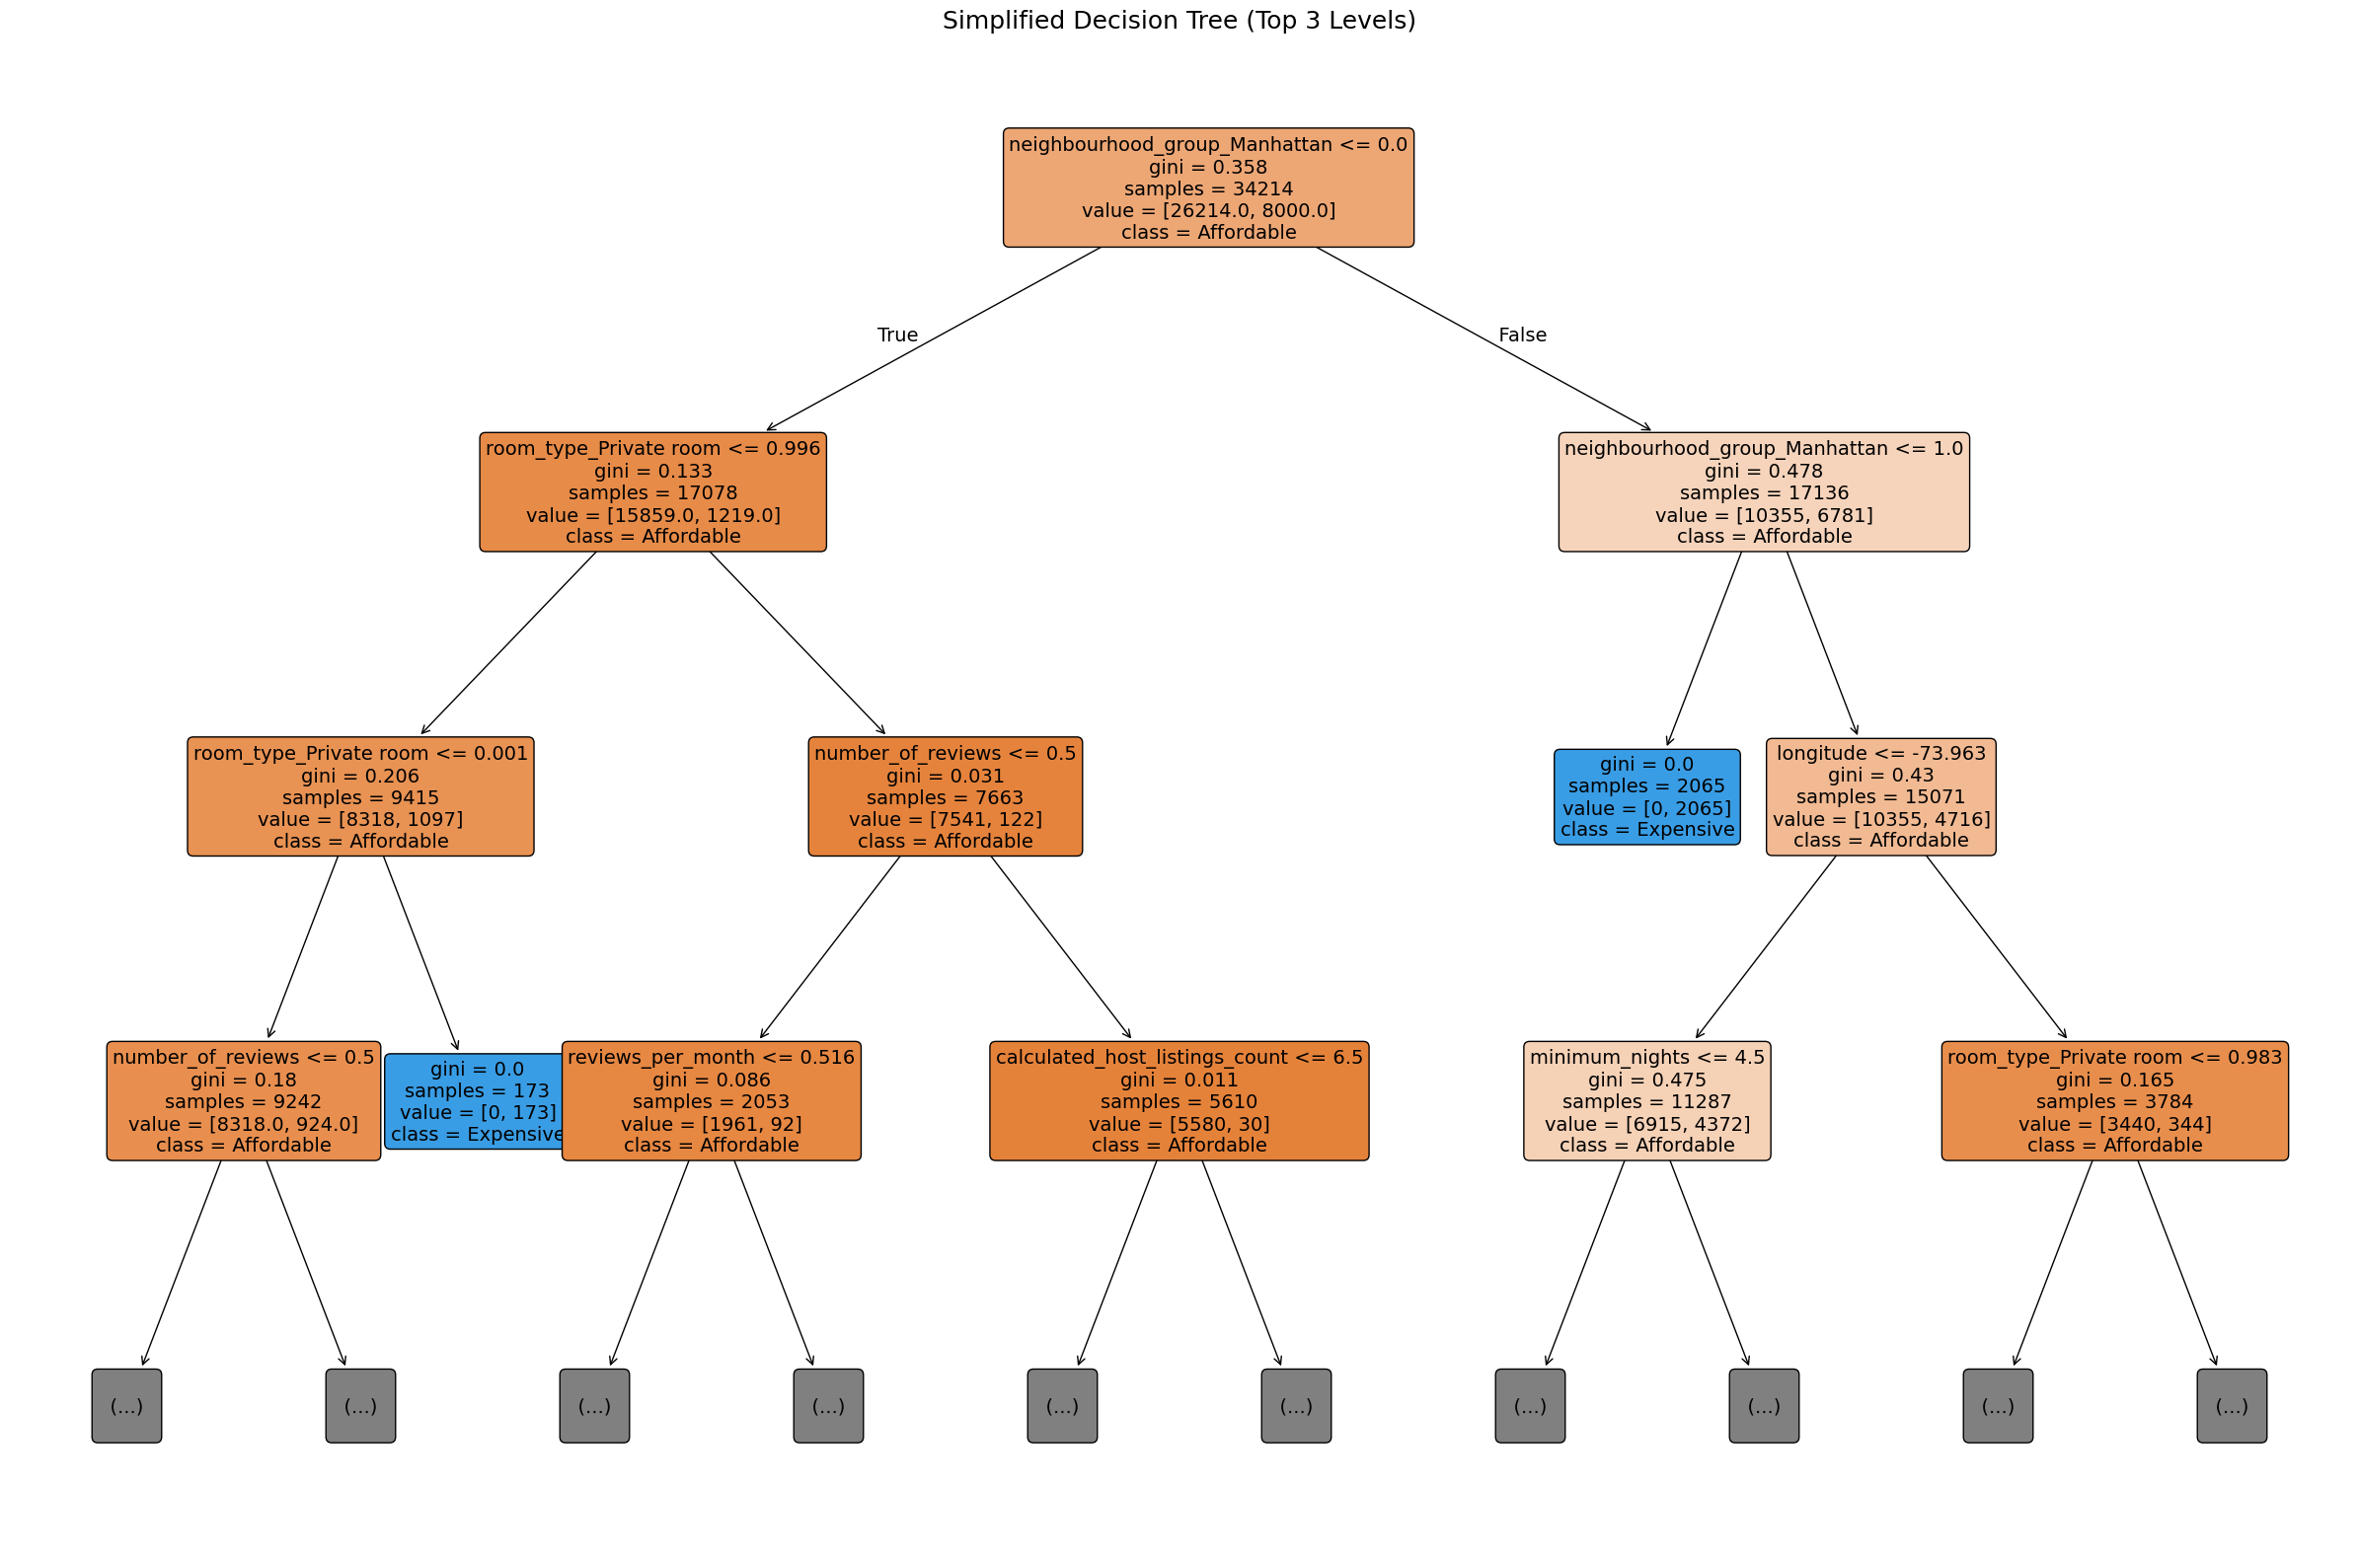

In [174]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 16))  # Bigger canvas for better readability

plot_tree(
    dtree_gs_search.best_estimator_,
    max_depth=3,  # Limit depth for simplicity
    filled=True,
    feature_names=X_train_rf.columns,
    class_names=dtree_gs_search.best_estimator_.classes_,
    rounded=True,
    fontsize=14  # Increase font size for clarity
)

plt.title("Simplified Decision Tree (Top 3 Levels)", fontsize=18)
plt.tight_layout()
plt.show()


Random Forest (Using the unscaled data)

Accuracy: 0.9588496609773206
Classification Report (Random Forest):
               precision    recall  f1-score   support

  Affordable       0.96      0.98      0.97      6554
   Expensive       0.94      0.88      0.91      2000

    accuracy                           0.96      8554
   macro avg       0.95      0.93      0.94      8554
weighted avg       0.96      0.96      0.96      8554



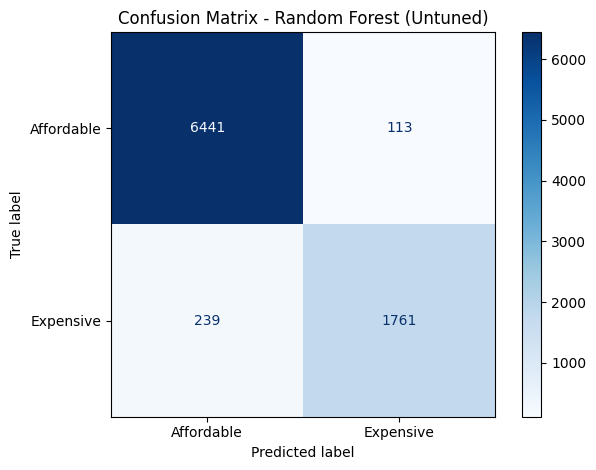

In [175]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict
rf_y_pred = rf_model.predict(X_test_rf)

# Evaluate
print("Accuracy:", accuracy_score(y_test_rf, rf_y_pred))
print("Classification Report (Random Forest):\n", classification_report(y_test_rf, rf_y_pred))

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_y_pred, labels=rf_model.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_)
rf_disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest (Untuned)")
plt.tight_layout()
plt.show()


Grid Search on Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9579144259995324
Classification Report:
               precision    recall  f1-score   support

  Affordable       0.96      0.98      0.97      6554
   Expensive       0.94      0.88      0.91      2000

    accuracy                           0.96      8554
   macro avg       0.95      0.93      0.94      8554
weighted avg       0.96      0.96      0.96      8554



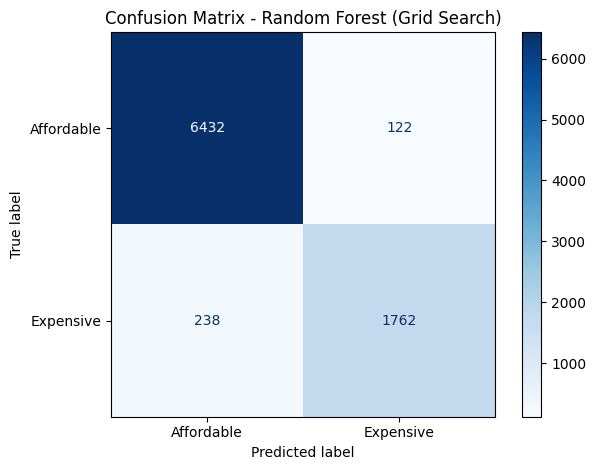

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Hyperparameter grid
rf_gs_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

#GridSearch
rf_gs_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_gs_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_gs_search.fit(X_train_rf, y_train_rf)

# Predict
rf_gs_y_pred = rf_gs_search.best_estimator_.predict(X_test_rf)

# Evaluate
print("Best Parameters:", rf_gs_search.best_params_)
print("Accuracy:", accuracy_score(y_test_rf, rf_gs_y_pred))
print("Classification Report:\n", classification_report(y_test_rf, rf_gs_y_pred))

# Confusion Matrix
rf_gs_cm = confusion_matrix(y_test_rf, rf_gs_y_pred, labels=rf_gs_search.best_estimator_.classes_)
rf_gs_disp = ConfusionMatrixDisplay(confusion_matrix=rf_gs_cm, display_labels=rf_gs_search.best_estimator_.classes_)
rf_gs_disp.plot(cmap='Blues', values_format='d')
plt.grid(False)
plt.title("Confusion Matrix - Random Forest (Grid Search)")
plt.tight_layout()
plt.show()


Feature Importance of Random Forest

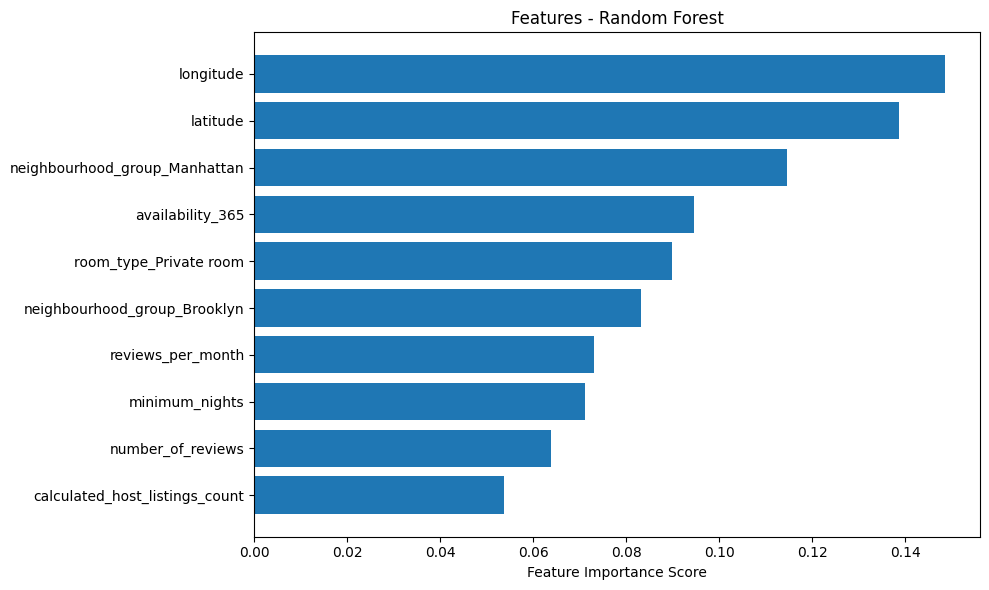

In [177]:
rf_importances = rf_gs_search.best_estimator_.feature_importances_

rf_feature_names = X_train_rf.columns

rf_importance_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
})

rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'][:10][::-1], rf_importance_df['Importance'][:10][::-1])
plt.xlabel("Feature Importance Score")
plt.title("Features - Random Forest")
plt.tight_layout()
plt.show()

ROC AUC Curve for Random Forest after Grid Search

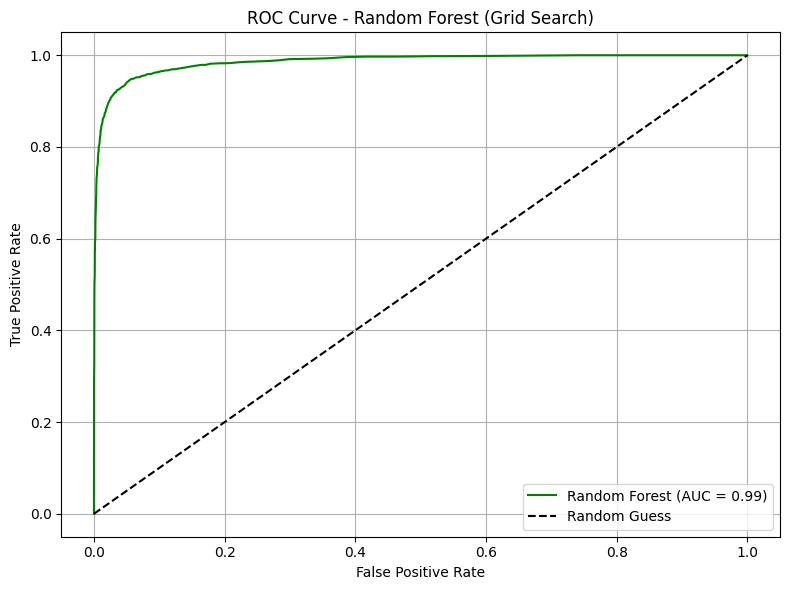

In [137]:
rf_gs_y_score = rf_gs_search.best_estimator_.predict_proba(X_test_rf)[:, 1]

rf_gs_fpr, rf_gs_tpr, _ = roc_curve(y_test_rf, rf_gs_y_score, pos_label='Expensive')
rf_gs_auc = auc(rf_gs_fpr, rf_gs_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_gs_fpr, rf_gs_tpr, label=f'Random Forest (AUC = {rf_gs_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Grid Search)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()